# Landsat 8 NDVI Analysis on the Cloud

This notebook demonstrates how to run a distributed calculation of NDVI using Landsat8 data stored on AWS S3. **What is unique about this workflow is that no data is downloaded!** All calculations are performed in memory across many distributed machines on the AWS Cloud. This is possible because the Landsat 8 data is stored in [Cloud-Optimized Geotiff](http://www.cogeo.org) format, which can be accessed remotely via [xarray](http://xarray.pydata.org/en/stable/) and [rasterio](https://rasterio.readthedocs.io/en/latest/) Python libraries. Distributed computing is enabled through a [Pangeo](http://pangeo-data.org) JupyterHub deployment with [Dask Kubernetes](https://github.com/dask/dask-kubernetes).

About Landsat 8:
https://landsat.usgs.gov/landsat-8 

About the AWS Landsat archive:
https://registry.opendata.aws/landsat-8/ 

A nice way to query this archive on S3 is the sat-search tool:
https://github.com/sat-utils/sat-search 

Date: August 15, 2018

Creators:
Scott Henderson, Daniel Rothenberg, and other Pangeo Sprint participants!

In [1]:
# Import required libraries
import os
import satsearch.main as main
import rasterio
import geopandas as gpd
import pandas as pd
import dask
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from dask_kubernetes import KubeCluster
from dask.distributed import Client
from dask.distributed import wait, progress

#import warnings
#warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
# Print versions
print('Xarray version: ', xr.__version__)
print('Dask version: ', dask.__version__)
print('Rasterio version: ', rasterio.__version__)
print('Geopandas version: ', gpd.__version__)

Xarray version:  0.10.8
Dask version:  0.18.2
Rasterio version:  1.0.2
Geopandas version:  0.4.0


In [21]:
# Set environment variables for cloud-optimized-geotiff efficiency
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='YES'
#os.environ['CURL_CA_BUNDLE']='/etc/ssl/certs/ca-certificates.crt'
os.environ['CPL_VSIL_CURL_ALLOWED_EXTENSIONS']='TIF'

## Use satsearch library to get a list of URLs to Landsat images stored on AWS S3

In [22]:
# Scenes from particular row, col are on same UTM grid
# Programmatic:
search_params = dict(date_from='1990-04-30',
                     date_to = '2018-08-30',
                     COLLECTION_CATEGORY = 'T1',
                     satellite_name = 'landsat-8',
                     row=27,
                     path=47,
                     # search by point if you don't know row and path:
                     #contains='-122.335167,47.608013', #Seattle, WA
                     )
scenes = main.main(**search_params)
#scenes.print_scenes()
scenes.save('archive.geojson')

OSError: Could not find a suitable TLS CA certificate bundle, invalid path: /etc/ssl/certs/ca-certificates.crt

In [23]:
gf = gpd.read_file('archive.geojson')

In [9]:
ls

0-test-satsearch.ipynb
1-test-rasterio-stack.ipynb
LICENSE
PangeoBoulderSprint2018-presentation.pdf
PangeoSpringLandsatGoogleCloud.ipynb
PangeoSprintLandsat-NDVI.ipynb
PangeoSprintLandsat-Simple.ipynb
PangeoSprintLandsatDraft.ipynb
README.md
archive.geojson
download-links-precollection.txt
download-links.txt
environment.yml
last-year.json
query.txt
response.json
scenes.json
seattle-point.geojson


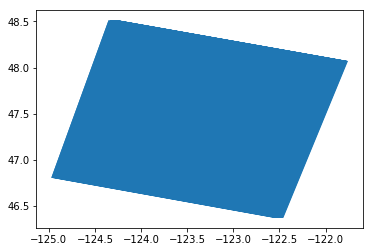

In [10]:
# Make sure all of these files are on the same grid
gf.plot()

## Launch Dask Kubernetes Cluster

In [12]:
# Select 10 'workers' under 'manual scaling' menu below and click 'Scale'
# Click on the Dashboard link to monitor calculation progress
#cluster = KubeCluster()
#cluster

In [13]:
# Attach Dask to the cluster
#client = Client(cluster)

## Load all Landsat bands into an xarray dataset


In [14]:
# Create a pandas dataframe with the product IDs that we need
df = gf.loc[:,['aws_index', 'product_id', 'date']]
df['datetime'] = pd.to_datetime(df.date)
df = df.sort_values('datetime').reset_index(drop=True)
df.head()

,aws_index,product_id,date,datetime
0,http://landsat-pds.s3.amazonaws.com/L8/047/027...,LC08_L1TP_047027_20130421_20170310_01_T1,2013-04-21,2013-04-21
1,http://landsat-pds.s3.amazonaws.com/L8/047/027...,LC08_L1TP_047027_20130523_20170310_01_T1,2013-05-23,2013-05-23
2,http://landsat-pds.s3.amazonaws.com/L8/047/027...,LC08_L1TP_047027_20130608_20170310_01_T1,2013-06-08,2013-06-08
3,http://landsat-pds.s3.amazonaws.com/L8/047/027...,LC08_L1TP_047027_20130624_20170309_01_T1,2013-06-24,2013-06-24
4,http://landsat-pds.s3.amazonaws.com/L8/047/027...,LC08_L1TP_047027_20130710_20180201_01_T1,2013-07-10,2013-07-10


In [15]:
print(df.date)

0     2013-04-21
1     2013-05-23
2     2013-06-08
3     2013-06-24
4     2013-07-10
5     2013-07-26
6     2013-08-11
7     2013-08-27
8     2013-09-12
9     2013-10-14
10    2013-10-30
11    2014-01-02
12    2014-01-18
13    2014-02-03
14    2014-02-19
15    2014-03-07
16    2014-03-23
17    2014-04-08
18    2014-04-24
19    2014-05-10
20    2014-05-26
21    2014-06-11
22    2014-06-27
23    2014-07-13
24    2014-07-29
25    2014-08-14
26    2014-09-15
27    2014-10-01
28    2014-11-18
29    2015-01-21
         ...    
63    2016-09-20
64    2016-10-22
65    2016-11-07
66    2016-11-23
67    2016-12-25
68    2017-01-10
69    2017-01-26
70    2017-02-11
71    2017-03-31
72    2017-04-16
73    2017-05-02
74    2017-05-18
75    2017-06-03
76    2017-06-19
77    2017-07-05
78    2017-07-21
79    2017-08-06
80    2017-08-22
81    2017-09-07
82    2017-09-23
83    2017-10-09
84    2017-10-25
85    2017-11-10
86    2017-12-12
87    2018-01-13
88    2018-02-14
89    2018-05-21
90    2018-06-

In [18]:
def create_landsat_dataset(aws_index, 
                           bands=[4,], 
                           chunks={'band': 1, 'x': 2048, 'y': 2048}):
    '''A function to load multiple land '''
    
    baseurl = aws_index.rstrip('/index.html')
    product_id = baseurl.split('/')[-1]
    
    datasets = []
    for band in bands:
        url = f'{baseurl}/{product_id}_B{band}.TIF'
        print(url)
        da = xr.open_rasterio(url, chunks=chunks)
        da = da.squeeze().drop(labels='band')
        ds = da.to_dataset(name=f'band{band}')
        datasets.append(ds)

    #DS = xr.merge(datasets)
    
    #return DS

In [20]:
# Load all the data, make note of errors if certain files don't load
datasets = []
dates = []
for i,row in df.iterrows():
    date = row.datetime
    try:
        ds = create_landsat_dataset(row.aws_index)
        datasets.append(ds)
        dates.append(date)
    except Exception as e:
        print('ERROR loading, skipping acquistion:', date)
        print(e)

http://landsat-pds.s3.amazonaws.com/L8/047/027/LC80470272013111LGN01/LC80470272013111LGN01_B4.TIF
http://landsat-pds.s3.amazonaws.com/L8/047/027/LC80470272013143LGN01/LC80470272013143LGN01_B4.TIF
http://landsat-pds.s3.amazonaws.com/L8/047/027/LC80470272013159LGN00/LC80470272013159LGN00_B4.TIF
http://landsat-pds.s3.amazonaws.com/L8/047/027/LC80470272013175LGN00/LC80470272013175LGN00_B4.TIF
http://landsat-pds.s3.amazonaws.com/L8/047/027/LC80470272013191LGN00/LC80470272013191LGN00_B4.TIF
http://landsat-pds.s3.amazonaws.com/L8/047/027/LC80470272013207LGN00/LC80470272013207LGN00_B4.TIF
http://landsat-pds.s3.amazonaws.com/L8/047/027/LC80470272013223LGN00/LC80470272013223LGN00_B4.TIF
http://landsat-pds.s3.amazonaws.com/L8/047/027/LC80470272013239LGN00/LC80470272013239LGN00_B4.TIF
http://landsat-pds.s3.amazonaws.com/L8/047/027/LC80470272013255LGN00/LC80470272013255LGN00_B4.TIF
http://landsat-pds.s3.amazonaws.com/L8/047/027/LC80470272013287LGN00/LC80470272013287LGN00_B4.TIF
http://landsat-pds.s

In [14]:
DS = xr.concat(datasets, dim=pd.DatetimeIndex(dates, name='time'))
print('Dataset size (Gb): ', DS.nbytes/1e9)

Dataset size (Gb):  95.525438624


In [15]:
DS

<xarray.Dataset>
Dimensions:  (time: 92, x: 8121, y: 7991)
Coordinates:
  * x        (x) float64 3.492e+05 3.492e+05 3.493e+05 3.493e+05 3.493e+05 ...
  * y        (y) float64 5.135e+06 5.135e+06 5.135e+06 5.135e+06 5.135e+06 ...
  * time     (time) datetime64[ns] 2013-04-21 2013-05-23 2013-06-08 ...
Data variables:
    band4    (time, y, x) float64 dask.array<shape=(92, 7991, 8121), chunksize=(1, 1627, 2048)>
    band5    (time, y, x) float64 dask.array<shape=(92, 7991, 8121), chunksize=(1, 1627, 2048)>

In [16]:
# extract a band from a specifc date
da = DS.sel(time='2013-04-21')['band4']
print('Dataset size (Gb): ', da.nbytes/1e9)
da
# NOTE: that this is still just a description of the file, 
# Only the metadata is in memory. Computation calls or plotting calls
# will force the necessary bytes to be transfered from S3 to memory

Dataset size (Gb):  0.519159288


<xarray.DataArray 'band4' (y: 7991, x: 8121)>
dask.array<shape=(7991, 8121), dtype=float64, chunksize=(1627, 2048)>
Coordinates:
  * x        (x) float64 3.492e+05 3.492e+05 3.493e+05 3.493e+05 3.493e+05 ...
  * y        (y) float64 5.135e+06 5.135e+06 5.135e+06 5.135e+06 5.135e+06 ...
    time     datetime64[ns] 2013-04-21
Attributes:
    crs:         +init=epsg:32610
    res:         (30.0, 30.0)
    is_tiled:    1
    nodatavals:  (nan,)

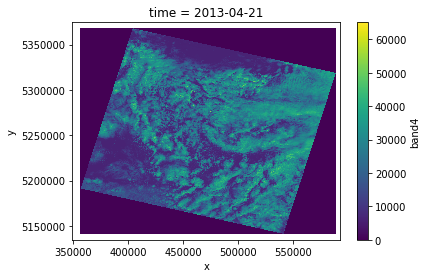

In [17]:
# This will take a while since 500Mb are transferred from S3
da.plot.imshow()

In [18]:
# Set up new variable (this is not computed)
NDVI = (DS['band5'] - DS['band4']) / (DS['band5'] + DS['band4'])
NDVI

<xarray.DataArray (time: 92, y: 7991, x: 8121)>
dask.array<shape=(92, 7991, 8121), dtype=float64, chunksize=(1, 1627, 2048)>
Coordinates:
  * x        (x) float64 3.492e+05 3.492e+05 3.493e+05 3.493e+05 3.493e+05 ...
  * y        (y) float64 5.135e+06 5.135e+06 5.135e+06 5.135e+06 5.135e+06 ...
  * time     (time) datetime64[ns] 2013-04-21 2013-05-23 2013-06-08 ...

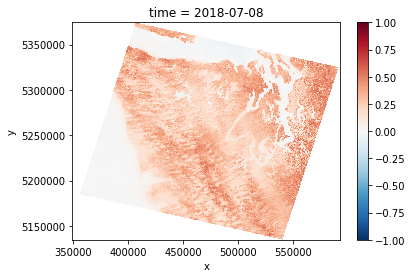

In [19]:
# Plot NDVI for a particular date
NDVI.sel(time='2018-07-08').plot.imshow()

In [25]:
# NOTE: Both of these methods will lead to errors.

# Runs on single pod local memory+disk as numpy arrays
#NDVI.compute() 

# Runs on all pods, but requires keeping the ENTIRE dataset in memory
#NDVI = NDVI.persist()

# Recall from above that our total cluster resources are:
# nworkers = 10
# ncores = 20
# memory = 60Gb
# So, NDVI persist() will try to keep out 95Gb dataset in 60Gb memory and consequently fail

#progress(NDVI)

In [20]:
#get standard deviation of nvdi (final array size should be ~500Mb)
ndviStd = NDVI.std().compute()
progress(ndviStd)

distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils - ERROR - Worker already exists tcp://192.168.45.70:38046
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/distributed/utils.py", line 644, in log_errors
    yield
  File "/opt/conda/lib/python3.6/site-packages/distributed/scheduler.py", line 1225, in add_worker
    raise ValueError("Worker already exists %s" % address)
Val

KilledWorker: ("('open_rasterio-getitem-dd6b1afffe09959914f1f6c07ab490e0', 2, 3)", 'tcp://192.168.30.132:36773')

distributed.utils - ERROR - Worker already exists tcp://192.168.15.196:37199
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/distributed/utils.py", line 644, in log_errors
    yield
  File "/opt/conda/lib/python3.6/site-packages/distributed/scheduler.py", line 1225, in add_worker
    raise ValueError("Worker already exists %s" % address)
ValueError: Worker already exists tcp://192.168.15.196:37199
distributed.core - ERROR - Worker already exists tcp://192.168.15.196:37199
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/distributed/core.py", line 321, in handle_comm
    result = yield result
  File "/opt/conda/lib/python3.6/site-packages/tornado/gen.py", line 1099, in run
    value = future.result()
  File "/opt/conda/lib/python3.6/site-packages/tornado/gen.py", line 315, in wrapper
    yielded = next(result)
  File "/opt/conda/lib/python3.6/site-packages/distributed/scheduler.py", line 1225, in add_worker
    raise Val

In [31]:
ndviStd

<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>

In [19]:
# Compute statistics of reduced dimension
# For example, std will have dimensions of 
ndviStd = NDVI.std()
ndviMean= NDVI.mean()

ndviMean, ndviStd = dask.compute(ndviMean, ndviStd)

distributed.utils - ERROR - Worker already exists tcp://192.168.180.4:34594
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/distributed/utils.py", line 644, in log_errors
    yield
  File "/opt/conda/lib/python3.6/site-packages/distributed/scheduler.py", line 1225, in add_worker
    raise ValueError("Worker already exists %s" % address)
ValueError: Worker already exists tcp://192.168.180.4:34594
distributed.core - ERROR - Worker already exists tcp://192.168.180.4:34594
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/distributed/core.py", line 321, in handle_comm
    result = yield result
  File "/opt/conda/lib/python3.6/site-packages/tornado/gen.py", line 1099, in run
    value = future.result()
  File "/opt/conda/lib/python3.6/site-packages/tornado/gen.py", line 315, in wrapper
    yielded = next(result)
  File "/opt/conda/lib/python3.6/site-packages/distributed/scheduler.py", line 1225, in add_worker
    raise ValueE

KilledWorker: ('open_rasterio-20f59ae0b8258e08fb82a07bfcdaba1d<this-array>-fae5e84a3b0737f294724e4ae3013e80', 'tcp://192.168.133.68:45842')

distributed.utils - ERROR - Worker already exists tcp://192.168.199.4:39789
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/distributed/utils.py", line 644, in log_errors
    yield
  File "/opt/conda/lib/python3.6/site-packages/distributed/scheduler.py", line 1225, in add_worker
    raise ValueError("Worker already exists %s" % address)
ValueError: Worker already exists tcp://192.168.199.4:39789
distributed.core - ERROR - Worker already exists tcp://192.168.199.4:39789
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/distributed/core.py", line 321, in handle_comm
    result = yield result
  File "/opt/conda/lib/python3.6/site-packages/tornado/gen.py", line 1099, in run
    value = future.result()
  File "/opt/conda/lib/python3.6/site-packages/tornado/gen.py", line 315, in wrapper
    yielded = next(result)
  File "/opt/conda/lib/python3.6/site-packages/distributed/scheduler.py", line 1225, in add_worker
    raise ValueE

In [23]:
DS

<xarray.Dataset>
Dimensions:  (time: 92, x: 8121, y: 7991)
Coordinates:
  * x        (x) float64 3.492e+05 3.492e+05 3.493e+05 3.493e+05 3.493e+05 ...
  * y        (y) float64 5.135e+06 5.135e+06 5.135e+06 5.135e+06 5.135e+06 ...
  * time     (time) datetime64[ns] 2017-02-18 2017-02-18 2017-02-18 ...
Data variables:
    band4    (time, y, x) float64 dask.array<shape=(92, 7991, 8121), chunksize=(1, 1627, 2048)>
    band5    (time, y, x) float64 dask.array<shape=(92, 7991, 8121), chunksize=(1, 1627, 2048)>

In [25]:
len(DS.time)

92